In [1]:
import os
import pandas as pd
import re
import numpy as np
import os
import time
from keras.preprocessing import image
from keras.layers import GlobalAveragePooling2D, Dense, Dropout,Activation,Flatten
from keras.models import load_model
from keras.layers import Input
from keras.models import Model
from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split
import nltk
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
from skimage.transform import resize as imresize
import pickle
import time
import sys

import keras, os, pickle, re, sklearn, string, tensorflow
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras.layers import Embedding
from keras.optimizers import Adadelta
from sklearn.model_selection import train_test_split
from keras import backend as K

import plotly.plotly as py
import plotly.figure_factory as ff
import plotly
plotly.tools.set_credentials_file(username='fayd0001', api_key='mp55R0mdKckewVsVQbvG')
import cv2

Using TensorFlow backend.
/Users/ezra/anaconda3/envs/tfdeeplearning/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)
/Users/ezra/anaconda3/envs/tfdeeplearning/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# KEEP IN MIND THAT THIS IS CHEST X-RAYS ONLY

######### STEP I #############
#### Reading in Directory ####

print("Reading in the image directories ...")

dir_test  = os.listdir('/Users/ezra/Desktop/explaining/exp_imgs/')


dir_test.remove('.DS_Store')

######### STEP II ############
#### Creating ID lists #######

print("Creating patient ID lists for training testing and validation sets...")

ids_test  = ['CXR'+re.findall(r'CXR(.*)_',i)[0] for i in dir_test]

###### TAKING CARE OF A PROBLEMATIC INSTANCE ############

    
if ('CXR1_1' in ids_test) :
    i = ids_test.index("CXR1_1")
    ids_test[i] = "CXR1"
###### TAKING CARE OF A PROBLEMATIC INSTANCE ############

print("There are " + str(len(ids_test)) + " documents in the testing set")

################# STEP III ####################
#### Using the Dataframe to grab the texts ####
print("Extracting the Doctor Notes ....")
df = pd.read_csv('/Users/ezra/research/new_data/ids_texts_labels.csv') # read in the dataframe
text_test  = [df[df['ID'] == i].Text.item() for i in ids_test]
print("-------------------------------------------------------------------")
print("Check If Consistent...")
print("-------------------------------------------------------------------")
print("")
print("There are " + str(len(text_test)) + " texts in the testing set")

################# STEP IV   ####################
#### Grabing and Preprocessing the images #####
print("-------------------------------------------------------------------")
print("Grabing and PreProcessing the images.....")
print("Will take a while...")
print("ignore skimage 0.15 Warning if you get it...")

# Def preprocessing function

def preprocess(img, crop=True, resize=True, dsize=(224, 224)):
    if img.dtype == np.uint8:
        img = img / 255.0

    if crop:
        short_edge = min(img.shape[:2])
        yy = int((img.shape[0] - short_edge) / 2)
        xx = int((img.shape[1] - short_edge) / 2)
        crop_img = img[yy: yy + short_edge, xx: xx + short_edge]
    else:
        crop_img = img

    if resize:
        norm_img = imresize(crop_img, dsize, preserve_range=True)
    else:
        norm_img = crop_img

    return (norm_img).astype(np.float32)

img_test  = np.array([preprocess(plt.imread('/Users/ezra/Desktop/explaining/exp_imgs/'+i)) for i in dir_test])

print("-------------------------------------------------------------------")
print("Check If Consistent...")
print("-------------------------------------------------------------------")
print("")
print("There are " + str(len(img_test)) + " images in the testing set")


################# STEP V   ####################
############ Grabing The Labels ###############

label_test  = [df[df['ID'] == i].Labels.item() for i in ids_test]

print("-------------------------------------------------------------------")
print("Check If Consistent...")
print("-------------------------------------------------------------------")
print("")
print("There are " + str(len(label_test)) + " labels in the testing set")

############ sick people ratio #####################
j = 0


j = 0

for i in label_test:
    if i == 1:
        j += 1

sick_ratio_test = j / len(label_test)
############ sick people ratio #####################

print("-------------------------------------------------------------------")
print("Check out your training, validation and testing label ratio below...")
print("-------------------------------------------------------------------")

print(str(100*sick_ratio_test) + "% of the samples are labeled as sick in the testing set")

### END OF PREPARING THE DATA ##

Reading in the image directories ...
Creating patient ID lists for training testing and validation sets...
There are 213 documents in the testing set
Extracting the Doctor Notes ....


/Users/ezra/anaconda3/envs/tfdeeplearning/lib/python3.5/site-packages/skimage/transform/_warps.py:105: UserWarning:

The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.

/Users/ezra/anaconda3/envs/tfdeeplearning/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning:

Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.



-------------------------------------------------------------------
Check If Consistent...
-------------------------------------------------------------------

There are 213 texts in the testing set
-------------------------------------------------------------------
Grabing and PreProcessing the images.....
Will take a while...
ignore skimage 0.15 Warning if you get it...
-------------------------------------------------------------------
Check If Consistent...
-------------------------------------------------------------------

There are 213 images in the testing set
-------------------------------------------------------------------
Check If Consistent...
-------------------------------------------------------------------

There are 213 labels in the testing set
-------------------------------------------------------------------
Check out your training, validation and testing label ratio below...
-------------------------------------------------------------------
62.91079812206573% o

In [3]:
# EMBEDDING
MAX_NUM_WORDS  = 15000
EMBEDDING_DIM  = 300
MAX_SEQ_LENGTH = 140
USE_GLOVE      = True

# MODEL
FILTER_SIZES   = [3,4,5]
FEATURE_MAPS   = [10,10,10]
DROPOUT_RATE   = 0.5

# LEARNING
BATCH_SIZE     = 200
NB_EPOCHS      = 20
RUNS           = 1
VAL_SIZE       = 0.2


def clean_doc(doc):
    """
    Cleaning a document by several methods:
        - Lowercase
        - Removing whitespaces
        - Removing numbers
        - Removing stopwords
        - Removing punctuations
        - Removing short words
    """
    stop_words = set(stopwords.words('english'))
    
    # Lowercase
    doc = doc.lower()
    # Remove numbers
    doc = re.sub(r"[0-9]+", "", doc)
    # Split in tokens
    tokens = doc.split()
    # Remove Stopwords
    tokens = [w for w in tokens if not w in stop_words]
    # Remove punctuation
    tokens = [w.translate(str.maketrans('', '', string.punctuation)) for w in tokens]
    # Tokens with less then two characters will be ignored
    tokens = [word for word in tokens if len(word) > 1]
    return ' '.join(tokens)

test_docs = [clean_doc(i) for i in text_test]

def max_length(lines):
    """
    Calculate the maximum document length
    """
    return max([len(s.split()) for s in lines])



test_tok = Tokenizer(num_words=MAX_NUM_WORDS)
test_tok.fit_on_texts(test_docs)
seq_test = test_tok.texts_to_sequences(test_docs)


# Padding all sequences to same length of `MAX_SEQ_LENGTH`
val = pad_sequences(seq_test, maxlen=MAX_SEQ_LENGTH, padding='post')


def create_glove_embeddings():
    print('Pretrained embeddings is loading...')

    embeddings_index = {}
    f = open('/Users/ezra/research/new_data/new_data_embed300.txt')
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    print('Found %s word vectors in GloVe embedding' % len(embeddings_index))

    embedding_matrix = np.zeros((MAX_NUM_WORDS, EMBEDDING_DIM))

    for word, i in tokenizer.word_index.items():
        if i >= MAX_NUM_WORDS:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return Embedding(input_dim=MAX_NUM_WORDS, output_dim=EMBEDDING_DIM,
                     input_length=MAX_SEQ_LENGTH,
                     weights=[embedding_matrix],
                     trainable=True
                    )


In [4]:
img_mod = load_model('weights/img_model_final.h5')
txt_mod = load_model('weights/text_model_final.h5')
mrg_mod = load_model('weights/full_model_final.h5')

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


/Users/ezra/anaconda3/envs/tfdeeplearning/lib/python3.5/site-packages/keras/engine/topology.py:1271: UserWarning:

The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.



In [5]:
img_mod.load_weights('/Users/ezra/Desktop/explaining/weights/image_weights_final.hdf5')
txt_mod.load_weights('/Users/ezra/Desktop/explaining/weights/textfinal_weights_best.hdf5')
mrg_mod.load_weights('/Users/ezra/Desktop/explaining/weights/full_weights_best_final.hdf5')

In [1]:
from IntegratedGradients import *

def integrated_lesion (img, img_mod):
    
    import pandas as pd
    import matplotlib.pyplot as plt
    import numpy
    import scipy.cluster.hierarchy as hcluster
    import math

    ig = integrated_gradients(img_mod)

    exp = ig.explain(img)
    
    lolnorm = cv2.normalize(exp, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    gray = cv2.cvtColor(lolnorm, cv2.COLOR_BGR2GRAY)
    allx = gray
    gray[gray < 0.70]  = 0 
    
    d = pd.DataFrame(0, index=np.arange((224*224)), columns=['val', 'y', 'x'])
    
    index = 0 
    for i in range(224):
        for j in range(224):
            d.iloc[index,0] = gray[i,j]
            d.iloc[index,1] = i
            d.iloc[index,2] = j
            index += 1
    d = d[(d[['val']] != 0).all(axis=1)]       
    xs = d.x.values
    ys = d.y.values
    pairs = np.array([[i,j] for i, j in zip(xs,ys)])
    
    
    data = pairs


    # clustering
    thresh = 10
    clusters = hcluster.fclusterdata(data, thresh, criterion="distance")
    
    d['cluster'] = clusters
    d['dummy'] = 1
    
    centers = d.groupby(['cluster']).mean()
    counts = d.groupby(['cluster']).sum()

    relevent_clusters = list(counts[counts.dummy > 1].index)
    
    
    cv_centers = []
    cv_rads = []
    for i in relevent_clusters:
    
        x_cent = int(centers[centers.index == i].x)
        y_cent = int(centers[centers.index == i].y)
    
        cv_centers.append((x_cent, y_cent))
    
        temp_x = list(d[d.cluster == i].x)
        temp_y = list(d[d.cluster == i].y)
        dists = []
        for j in range(len(temp_x)):
        
            dists.append(math.hypot(y_cent - temp_y[j] , x_cent - temp_x[j]))
        
        cv_rads.append(max(dists) + 5)
        
    for i in range( len (cv_rads)):
        alpha = (cv2.circle(img,(cv_centers[i]),int(cv_rads[i]), 1))
        
    return(alpha, gray, allx)

Using TensorFlow backend.


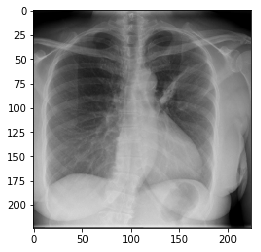

In [7]:
plt.imshow(img_test[139])

In [9]:
explaination_of_image = integrated_lesion(img_test[139], img_mod)

Evaluated output channel (0-based index): All
Building gradient functions
Progress: 100.0%
Done.


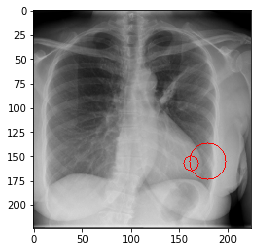

In [10]:
plt.imshow(explaination_of_image[0])

In [12]:
text_test[139]

'A XXXX-year-old female follow-up XXXX acquired pneumonia. XXXX airspace opacity in the left upper lung which may represent streaky atelectasis or resolving pneumonia. There is a XXXX airspace opacity in the left upper lung. Heart size within normal limits. Mild calcification of the aortic XXXX. No pneumothorax or pleural effusions.'

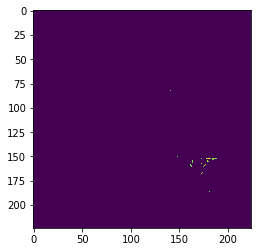

In [13]:
plt.imshow(explaination_of_image[1])

In [68]:
from IntegratedGradients import *

ig = integrated_gradients(img_mod)

exp = ig.explain(img_test[-4])

Evaluated output channel (0-based index): All
Building gradient functions
Progress: 100.0%
Done.


## Img evaluations

In [13]:
predict_img = img_mod.predict(img_test)

In [14]:
img_mod.evaluate(x = img_test, y = label_test)

213/213 [==============================] - 69s 323ms/step


[0.556052631615473, 0.7417840395175236]

In [15]:
pred_img = [int(round(predict_img[i][0])) for i in range (len(predict_img))]

## Txt evaluations

In [16]:
predict_txt = txt_mod.predict(val)

In [17]:
txt_mod.evaluate(x = val, y = label_test, verbose=1)

213/213 [==============================] - 2s 9ms/step


[1.9631656995961364, 0.7230046967945188]

## Multi-modal evaluations

In [18]:
mrg_mod.evaluate([img_test, val], label_test)

213/213 [==============================] - 70s 326ms/step


[1.473093398300135, 0.7511737105991919]

In [19]:
predict_mrg = mrg_mod.predict([img_test, val])

### Image only Explainations patients: 5 8 11 13 14 16

In [13]:
# predictions 5 8 11 13 14 16

improved = [ 2,8 ,200, 13 ,14 ,16]
print('Lets take 6 random examples of the improved data points the image classifier classified correctly')

temp = [i for i in improved[0:6]]


print('image classifier predicted: ' + str(pred_img[temp[0]]) + ' while the ground truth was: ' + str(label_test[temp[0]])) 
print('image classifier predicted: ' + str(pred_img[temp[1]]) + ' while the ground truth was: ' + str(label_test[temp[1]])) 
print('image classifier predicted: ' + str(pred_img[temp[2]]) + ' while the ground truth was: ' + str(label_test[temp[2]])) 
print('image classifier predicted: ' + str(pred_img[temp[3]]) + ' while the ground truth was: ' + str(label_test[temp[3]]))
print('image classifier predicted: ' + str(pred_img[temp[4]]) + ' while the ground truth was: ' + str(label_test[temp[4]])) 
print('image classifier predicted: ' + str(pred_img[temp[5]]) + ' while the ground truth was: ' + str(label_test[temp[5]]))

qq = ['dummy',(img_test[temp[0]]),(img_test[temp[1]]), (img_test[temp[2]]), (img_test[temp[3]]), (img_test[temp[4]]), (img_test[temp[5]])]

Lets take 6 random examples of the improved data points the image classifier classified correctly
image classifier predicted: 1 while the ground truth was: 1
image classifier predicted: 1 while the ground truth was: 1
image classifier predicted: 1 while the ground truth was: 1
image classifier predicted: 1 while the ground truth was: 1
image classifier predicted: 1 while the ground truth was: 1
image classifier predicted: 1 while the ground truth was: 1


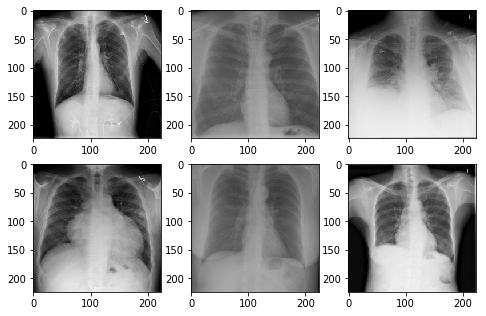

In [14]:
w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 3
rows = 3
for i in range(1, 7):
    fig.add_subplot(rows, columns, i)
    plt.imshow(qq[i])
plt.show()

In [37]:
import theano
import theano.tensor as T
import keras.backend as K



outputTensor = img_mod.output
listOfVariableTensors = img_mod.inputs
gradients = K.gradients(outputTensor, listOfVariableTensors)
trainingInputs = img_test[[11 ,11 ,11, 11 ,11 ,11]]


def changeImageSize(maxWidth, 
                    maxHeight, 
                    image):
    
    widthRatio  = maxWidth/image.size[0]
    heightRatio = maxHeight/image.size[1]

    newWidth    = int(widthRatio*image.size[0])
    newHeight   = int(heightRatio*image.size[1])

    newImage    = image.resize((newWidth, newHeight))
    return newImage

qq1 = [(img_test[[ 11,11 ,11, 11 ,11 ,11]])]
qq1np = np.asarray(qq1)
sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())
qq1np = qq1np.reshape(6,224,224,3)
evaluated_gradients = sess.run(gradients, feed_dict={img_mod.input: qq1np})

a = evaluated_gradients
new = [cv2.normalize(i, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F) for i in a[0]]

tt = []

for i in new:
    i[np.where( i < 0.78)] = 0 
    tt.append(i)
    
    
from PIL import Image
for i, j in zip([11,11,11,11], [2,3,4,5]):    

    # Take two images for blending them together   
    image1 = Image.fromarray((np.int8(tt[j]*255)), 'RGB')
    image2 = Image.open("/Users/ezra/Desktop/explaining/exp_imgs/" + dir_test[i])

    image3 = changeImageSize(500, 500, image1)
    image4 = changeImageSize(500, 500, image2)


    # Make sure images got an alpha channel
    image5 = image3.convert("RGBA")
    image6 = image4.convert("RGBA")

    # Display the images

    # alpha-blend the images with varying values of alpha
    alphaBlended1 = Image.blend(image5, image6, alpha=.5)

    # Display the alpha-blended images
    alphaBlended1.show()



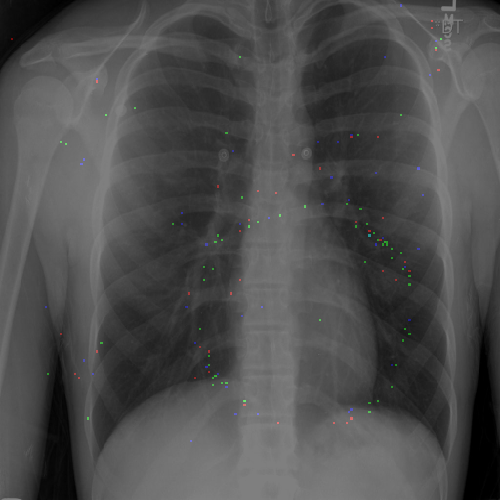

In [35]:
alphaBlended1

### Normal Images

In [22]:
import theano
import theano.tensor as T
import keras.backend as K



outputTensor = img_mod.output
listOfVariableTensors = img_mod.inputs
gradients = K.gradients(outputTensor, listOfVariableTensors)
trainingInputs = img_test[[6,9]]


def changeImageSize(maxWidth, 
                    maxHeight, 
                    image):
    
    widthRatio  = maxWidth/image.size[0]
    heightRatio = maxHeight/image.size[1]

    newWidth    = int(widthRatio*image.size[0])
    newHeight   = int(heightRatio*image.size[1])

    newImage    = image.resize((newWidth, newHeight))
    return newImage

qq1 = [(img_test[[ 6,9]])]
qq1np = np.asarray(qq1)
sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())
qq1np = qq1np.reshape(2,224,224,3)
evaluated_gradients = sess.run(gradients, feed_dict={img_mod.input: qq1np})

a = evaluated_gradients
new = [cv2.normalize(i, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F) for i in a[0]]

tt = []

for i in new:
    i[np.where( i < 0.78)] = 0 
    tt.append(i)
    
    
from PIL import Image
  

    # Take two images for blending them together   
image1 = Image.fromarray((np.int8(tt[0]*255)), 'RGB')
image2 = Image.open("/Users/ezra/Desktop/explaining/exp_imgs/" + dir_test[6])

image3 = changeImageSize(500, 500, image1)
image4 = changeImageSize(500, 500, image2)


    # Make sure images got an alpha channel
image5 = image3.convert("RGBA")
image6 = image4.convert("RGBA")

    # Display the images

    # alpha-blend the images with varying values of alpha
alphaBlended1 = Image.blend(image5, image6, alpha=.5)

    # Display the alpha-blended images
alphaBlended1.show()



### Text only Explainations patients

In [20]:
pred_mrg = []
for i in predict_mrg:
    pred_mrg.append(int(round(i[0])))

In [21]:
pred_img = []
for i in predict_img:
    pred_img.append(int(round(i[0])))

In [22]:
pred_txt = []
for i in predict_txt:
    pred_txt.append(int(round(i[0])))

In [23]:
improved = []

for i in range(len(predict_txt)):
    if pred_mrg[i] == label_test[i] :
        if pred_txt[i] != pred_mrg[i]:
            improved.append(i) 
            
print(str(len(improved)) + ' data points were classified better')

24 data points were classified better


In [38]:
predict_txt

array([[0.4943752 ],
       [0.783089  ],
       [0.7534161 ],
       [0.4454052 ],
       [0.7514227 ],
       [0.88531756],
       [0.5074387 ],
       [0.6303295 ],
       [0.7113689 ],
       [0.51557386],
       [0.50145215],
       [0.80731094],
       [0.51661927],
       [0.6105834 ],
       [0.6626563 ],
       [0.5515139 ],
       [0.76342326],
       [0.8904681 ],
       [0.45566517],
       [0.54825014],
       [0.5351953 ],
       [0.4842664 ],
       [0.5344584 ],
       [0.67449814],
       [0.51059484],
       [0.65696687],
       [0.7624593 ],
       [0.6539239 ],
       [0.5271308 ],
       [0.8064963 ],
       [0.8022011 ],
       [0.70834947],
       [0.5351953 ],
       [0.5579075 ],
       [0.5325701 ],
       [0.83665055],
       [0.5595111 ],
       [0.49092498],
       [0.68815047],
       [0.5245089 ],
       [0.6233224 ],
       [0.49960744],
       [0.8437074 ],
       [0.6781342 ],
       [0.6753802 ],
       [0.41856563],
       [0.67052597],
       [0.524

In [19]:
dir_test[11]

'CXR3435_IM-1662-1001.png'

In [20]:
df[df["ID"] == "CXR3435"].Text.item()

'XXXX-year-old female preoperative for spinal surgery XXXX 14, XXXX. No XXXX chest complains. 1. There is cardiomegaly. No pulmonary edema. Lungs symmetrically aerated and clear of infiltrate or consolidation. No pneumothorax or pleural effusion. S-shaped curvature thoracic spine noted. 2. Left upper quadrant peripherally calcified focus 3.8 XXXX XXXX splenic and origin and may represent benign cyst but is not XXXX to be further localized or characterized on XXXX film. Vascular aneurysm would be possible but thought less XXXX. '

In [44]:
import theano
import theano.tensor as T
import keras.backend as K


outputTensor = txt_mod.output
listOfVariableTensors = txt_mod.inputs
gradients = K.gradients(outputTensor, listOfVariableTensors)
trainingInputs = val

In [45]:
trainingInputs.shape

(213, 140)

In [46]:
gradients = K.gradients(txt_mod.outputs, txt_mod.layers[1].output)
sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())
evaluated_gradients = sess.run(gradients, feed_dict={txt_mod.input: np.asarray(trainingInputs[5:8])})
evaluated_gradients[0].shape
a = evaluated_gradients[0][0]
a = a.reshape(42000)
norms = (a-min(a))/(max(a)-min(a))
norms.shape

(42000,)

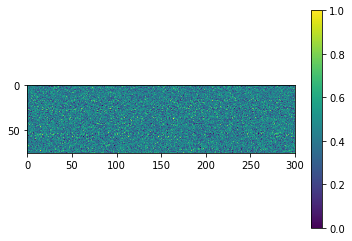

In [47]:
testtext = df[df["ID"] == "CXR1292"].Text.tolist()[0]
op = len(testtext.split())
ff = norms.reshape([140,300])
qq = ff[0:op]

imgplot = plt.imshow(qq)
plt.colorbar()

In [53]:
symbol = [testtext.split()]
element = [qqq]
colorscale = [[0, '#66475e'], [1, '#ecbfe0']]
font_colors = ['#efecee', '#3c3636']


z = [list(norms2)]

# Display element name and atomic mass on hover

In [54]:
import plotly.figure_factory as ff

hover= list(range(len(symbol)))
for x in range(len(symbol)):
    hover[x] = [i  for i in element[x]]

colorscale = [[0, '#66475e'], [1, '#ecbfe0']]
font_colors = ['#efecee', '#3c3636']    
    
# Invert Matrices
symbol = symbol[::-1]
hover = hover[::-1]
z = z[::-1]


# Make Annotated Heatmap
pt = ff.create_annotated_heatmap(z, annotation_text=symbol, text=hover,
                                 colorscale=colorscale, font_colors= font_colors, hoverinfo='text')
pt.layout.title = 'Doctor Notes'

py.iplot(pt, filename='periodic_table')